# Convolutional Neural Networks

This notebook makes extensive use of examples and figures from [here](http://cs231n.github.io/convolutional-networks/), which is a great reference for further details.

Recall the fully connected neural network.

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=300>

As discussed last week, the fully connected neural network becomes cumbersome when we start considering image recognition; it needs *lots* of weights, and isn't designed to take advantage of spatial features in the inputs.  This is where CNNs become powerful.

<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg" width=300>

CNNs preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and therefore weights).

The layers used to build CNN *architectures* fall into three categories:
 1. Convolutional Layer
 1. Pooling Layer
 1. Fully-Connected Layer

## Convolutional layer

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" width=300>

Convolutional layers consist of a set of filters that apply over a small spatial area, but the full depth of the input.  The example above shows on the left a [32x32x3] input volume (width 32, height 32 image with RGB color channels).  The volume on the right is an example of a convolutional layer, with a particular **depth column** highlighted which takes as input *only* the highlighted region of the input volume.  The spatial extent of the area covered by a depth column is referred to as the **receptive field**.

The dimensions of the *output volume* are decided by 3 hyperparameters: **depth**, **stride**, and **zero-padding**.  We can compute the size of the output volume based on the volume size $W$, the receptive field size of the convolution layer $F$, their applied stride $S$, and the amount of zero padding used $P$.

Based on these parameters, the number of neurons in the convolution layer is $(W−F+2P)/S+1$. 

<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">

Above is a 1-D example with inputs on the bottom in gray ($W=5$), and two different examples of a convolutional layer in yellow, both with receptive field $F=3$.

*Left*: This is a convolutional layer with stride $S = 1$, meaning we need ($5 - 3 + 2)/1+1 = 5$ neurons (i.e., outputs).

*Right*: Layer with stride $S = 2$, meaning an output of size $(5 - 3 + 2)/2+1 = 3$.

Note how on the left the zero padding allowed us to have the same number of outputs as inputs.  This is a common use of zero-padding.

### Parameter sharing

We can dramatically reduce the number of parameters involved in a convolutional layer by making the assumption that if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2).

In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [7x7x3] has 3 depth slices, each of size [7x7]), we are going to constrain the neurons in each depth slice to use the same weights and bias. All $7\times7$ neurons in each depth slice will now be using the same parameters.

<img src="https://harishnarayanan.org/images/writing/artistic-style-transfer/conv-layer.gif">

## Pooling

Pooling layers act to reduce the dimension of the propagated volume, reducing the number of weights going forward, reducing cost and reducing the chances of over-fitting.  It operates independently on each depth slice.  A common operation is to take the MAX over a region.

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width=300>

For example,
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width=500>

**NOTE**: These are being used less and less these days, in favor of other methods sudh as strided convolutions seen above.



# Example: MNIST

In [110]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1' #If you installed tensorflow to work with a GPU this will disable it
import os.path
import shutil
import numpy as np
import tensorflow as tf

Let's return to the MNIST hand-written digits data set.  First we'll download some external images that will be useful for visualizations later.

`TensorFlow` is an *incredibly* powerful tool, but it can be cumbersom to work with.  [keras](https://keras.io/) is a higher-level neural network API that uses `TensorFlow` (amond other things) under the hood, but allows you to networks wtih a lot less stress.

In [111]:
from matplotlib import pyplot as plt

In [112]:
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
n_targets=np.max(y_test)+1


lookup_dict={
    0:'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot' 
}
labels=lookup_dict.values()
#Check to make sure labels are in the right order (not guarentted in python < 3.7)
assert(all([v==lookup_dict[i] for i,v in enumerate(labels) ]) )

print(X_train.shape)

(60000, 28, 28)


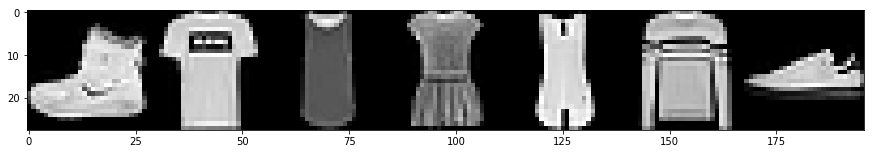

In [113]:
f=plt.figure(figsize=(15,3))
plt.imshow(np.hstack(X_train[0:7]),cmap='gray') #hstack aranges the first 7 images into one long image

In [114]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [115]:
print(X_train.dtype, X_train.max())

uint8 255


Notice that the pixel values imported as an integer array that saturates at `255`.  Let's turn the data into floats $\in [0, 1]$.

In [116]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [117]:
print(y_train.shape)
print(y_train[:10])

(60000,)
[9 0 0 3 0 2 7 2 5 5]


The results are stored as labels, but we'll want to work with a one-hot representation.  `keras` has a utility to make this conversion easy.

In [118]:
Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test =  tf.keras.utils.to_categorical(y_test, 10)

In [119]:
print(Y_train.shape)
print(Y_train[:10])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## The Model

We'll now build our model. A model in keras represents how to go from a set of inputs to a set of outputs, through a series of layers (For example CNN layers). Lets start by creating an input layer


In [120]:
cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
print(cnn_input)

Tensor("input_8:0", shape=(?, 28, 28, 1), dtype=float32)


Our first layer (after the input layer) will be a convolutional layer with `32` filters.  As the first layer, we need to tell it what input shape to expect (later layers will automatically determine this from the last layer that was added).

In [121]:
cnn_layer1=tf.keras.layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))(cnn_input) #Notice here calling the layer with cnn_input as an argument connects the input layer to this layer 

Just to demonstrate what's going on under the hood, we can print the current output shape of the model, which is the information that's fed into layers as we add them on.

In [122]:
print(cnn_layer1)

Tensor("conv2d_13/Relu:0", shape=(?, 26, 26, 32), dtype=float32)


Now let's add on another `32`-filter convolutional layer, following by a 2-D pooling layer with a pooling size of `2x2`.

In [123]:
cnn_layer2=tf.keras.layers.Convolution2D(32, (3, 3), activation='relu')(cnn_layer1)
max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_layer2)

Next we'll add on a *dropout* layer.  This layer will set the specified fraction of inputs to `0`, which can be useful for avoiding over fitting.  We'll drop $25\%$ of the inputs with this layer.   

In [124]:
dropout=tf.keras.layers.Dropout(0.25)(max_pool)

Next we'll add a fully connected layer with `128` nodes, making sure to flatten the volume before passing to this layer.

In [125]:
flat=tf.keras.layers.Flatten()(dropout)
dense1=tf.keras.layers.Dense(128, activation='relu')(flat)

We'll now add one final $25\%$ dropout layer for good measure, followed by the output layer.

In [126]:
dropout_output=tf.keras.layers.Dropout(0.5)(dense1)
output_no_activation=tf.keras.layers.Dense(n_targets, activation='softmax')(dropout_output)
output=tf.keras.layers.Activation('softmax')(output_no_activation)


# Building the Model
tf.keras.models.Model([input_layer],[output_layer])

In [127]:
model=tf.keras.models.Model([cnn_input],[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               589952    
__________

Now that we've built our full model it's time to compile it, specifying the loss function, optimizer, and any metrics we want to look at, and fit on the training data.

In [128]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [129]:
history=model.fit(X_train, Y_train, 
          batch_size=32, epochs=10, verbose=1,
         validation_data=(X_test,Y_test)
         )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 251us/step - loss: 1.7170 - acc: 0.7459 - val_loss: 1.6722 - val_acc: 0.7876
Epoch 2/10
60000/60000 [==============================] - 14s 240us/step - loss: 1.6669 - acc: 0.7940 - val_loss: 1.6602 - val_acc: 0.8017
Epoch 3/10
60000/60000 [==============================] - 14s 240us/step - loss: 1.6564 - acc: 0.8047 - val_loss: 1.6487 - val_acc: 0.8111
Epoch 4/10
60000/60000 [==============================] - 14s 240us/step - loss: 1.6498 - acc: 0.8114 - val_loss: 1.6444 - val_acc: 0.8164
Epoch 5/10
60000/60000 [==============================] - 14s 238us/step - loss: 1.6126 - acc: 0.8487 - val_loss: 1.5840 - val_acc: 0.8767
Epoch 6/10
60000/60000 [==============================] - 14s 235us/step - loss: 1.5841 - acc: 0.8765 - val_loss: 1.5743 - val_acc: 0.8874
Epoch 7/10
60000/60000 [==============================] - 14s 236us/step - loss: 1.5796 - acc: 0.8809 - val_loss: 1.

In [130]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("loss: {}, accuracy: {}".format(*score))

loss: 1.5629801820755005, accuracy: 0.8982


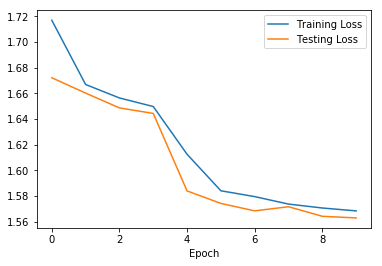

In [131]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [132]:
# Prediction

(10000, 10)


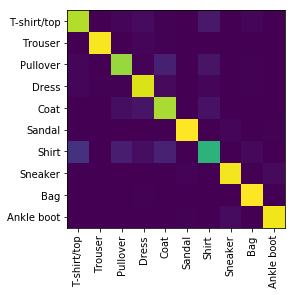

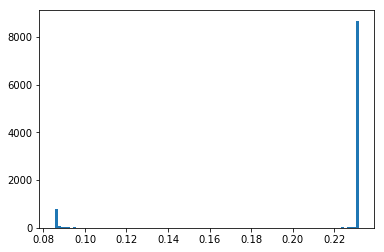

Guess: T-shirt/top /Truth: Dress


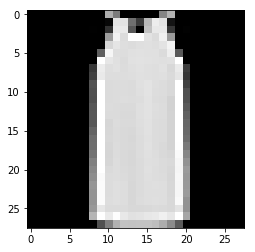

Guess: Shirt /Truth: Pullover


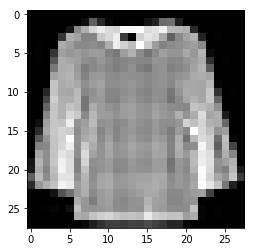

Guess: Dress /Truth: Coat


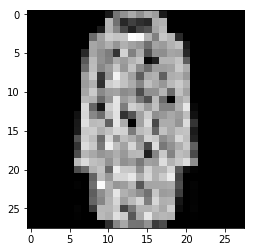

Guess: Sneaker /Truth: Bag


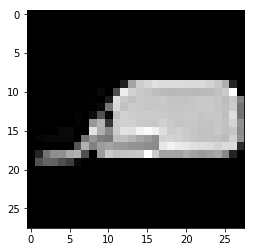

Guess: T-shirt/top /Truth: Shirt


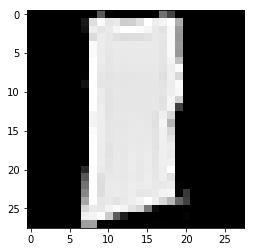

In [133]:
def check(model,X_test,Y_test):
    pred=model.predict(X_test)
    print(pred.shape)
    best_guess=np.argmax(pred,axis=1)

    confusion_matrix=np.zeros((n_targets,n_targets))
    for truth,guess in zip(y_test,best_guess): #Note lower case y for the data without 1-hot encoding    
        confusion_matrix[truth,guess]+=1

    plt.imshow(confusion_matrix)
    plt.xticks(range(0,10),labels,rotation=90)
    plt.yticks(range(0,10),labels)

    plt.show()
    np.sum(best_guess!=y_test)

    prediction_for_true_value=[p[i] for p,i in zip(pred,y_test)  ]

    bins=plt.hist(prediction_for_true_value,bins=100)
    worst=np.argsort(prediction_for_true_value)


    plt.show()
    plt.show()

    for index in worst[0:5]:
        print("Guess:", lookup_dict[best_guess[index]], "/Truth:",lookup_dict[y_test[index]])
        plt.imshow(np.squeeze(X_test[index]),cmap='gray')

        plt.show()


check(model,X_test,Y_test)




In [134]:
pred[0],best_guess[0]

(array([0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.08533674,
        0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.23196931],
       dtype=float32), 9)

In [167]:
#Lets Put of this together into some helpful functions
def build_model(dropout_rate=0.25,nfilters=32,use_leakyRelu=False,activation='relu'):
    cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
    cnn_layer1=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_input) #Notice here calling the layer with cnn_input as an argument connects the input layer to this layer 
    cnn_layer2=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_layer1)
    max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_layer2)
    dropout=tf.keras.layers.Dropout(dropout_rate)(max_pool)
    flat=tf.keras.layers.Flatten()(dropout)
    
    dense1=tf.keras.layers.Dense(128, activation=activation)(flat)

    dropout_output=tf.keras.layers.Dropout(dropout_rate)(dense1)
    output_no_a=tf.keras.layers.Dense(10)(dropout_output)
    output=tf.keras.layers.Activation('softmax')(output_no_a)
    model=tf.keras.models.Model([cnn_input],[output])
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model
    
def plot_history(history):
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    

# Dropout
Try a model without dropout

In [145]:
import numpy as np
print(X_train.shape)
train_data=np.random.choice(range(0,len(X_train))  ,500 )

(60000, 28, 28, 1)


Dropout Rate  0
Test loss: 1.4316232131958009, Test accuracy: 0.8004
Train loss: 3.154592683131341e-05, Train accuracy: 1.0


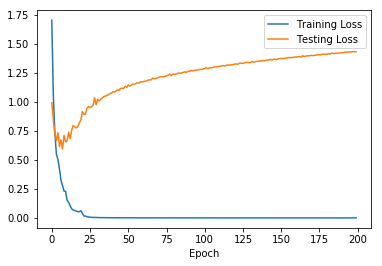

Dropout Rate  0.5
Test loss: 1.2856228104710579, Test accuracy: 0.8058
Train loss: 8.961730567534687e-05, Train accuracy: 1.0


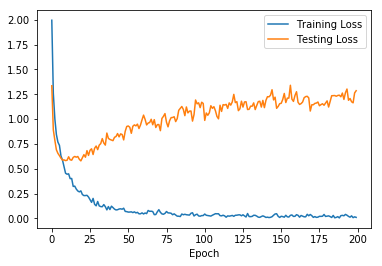

Dropout Rate  0.7
Test loss: 0.9673007047891616, Test accuracy: 0.8173
Train loss: 0.002151850759284571, Train accuracy: 1.0


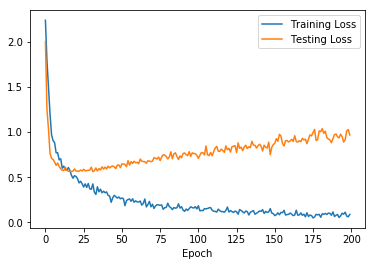

Dropout Rate  0.9
Test loss: 0.5907942924976349, Test accuracy: 0.7606
Train loss: 0.37601907169818877, Train accuracy: 0.8459999995231628


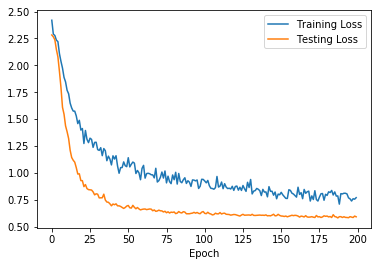

In [153]:

for rate in [0,0.5,0.7,0.9]:
    new_model=build_model(dropout_rate=rate)
    print('Dropout Rate ',rate)
    history=new_model.fit(X_train[train_data], Y_train[train_data], 
          batch_size=32, epochs=200, verbose=0,
         validation_data=(X_test,Y_test) )
    score = new_model.evaluate(X_test, Y_test, verbose=0)
    print("Test loss: {}, Test accuracy: {}".format(*score))

    score = new_model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
    print("Train loss: {}, Train accuracy: {}".format(*score))

    
    plot_history(history)


In [138]:
validation_data=(X_test,Y_test) 
score = new_model.evaluate(X_test, Y_test, verbose=0)
print("loss: {}, accuracy: {}".format(*score))

loss: 0.6042769987583161, accuracy: 0.7738


(10000, 10)


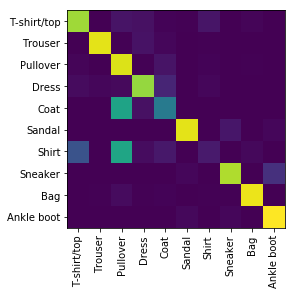

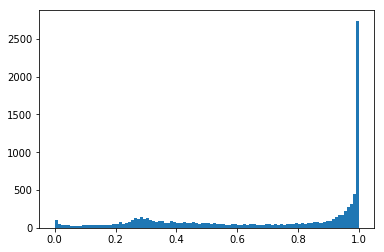

Guess: Sandal /Truth: T-shirt/top


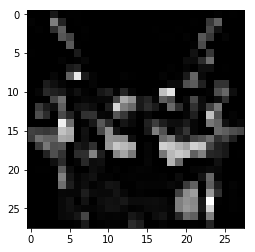

Guess: Pullover /Truth: Trouser


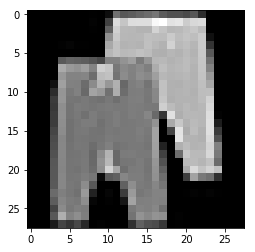

Guess: Bag /Truth: T-shirt/top


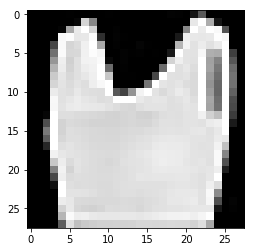

Guess: Sandal /Truth: T-shirt/top


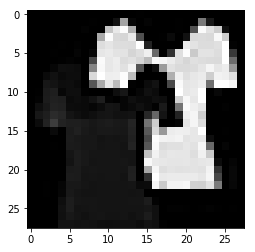

Guess: Bag /Truth: T-shirt/top


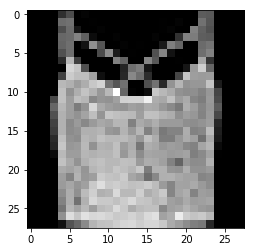

In [154]:
check(new_model,X_test,Y_test)

In [141]:
np.max(grads)


nan

In [155]:
# Activations


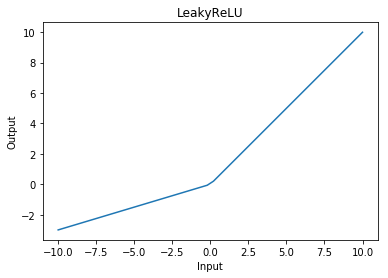

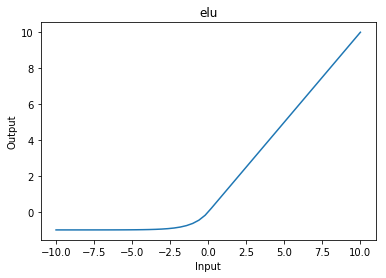

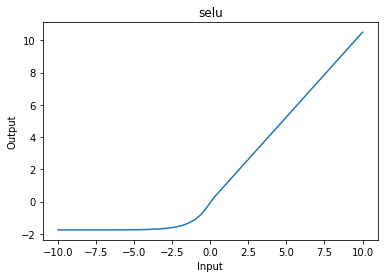

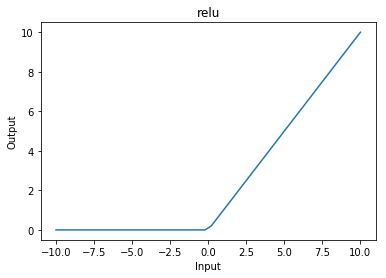

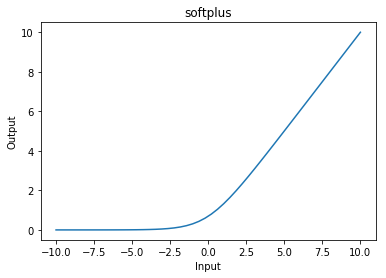

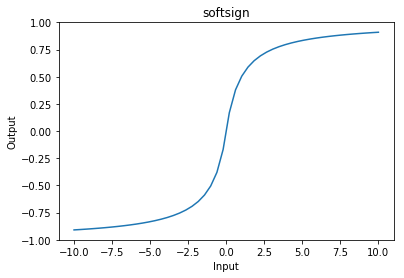

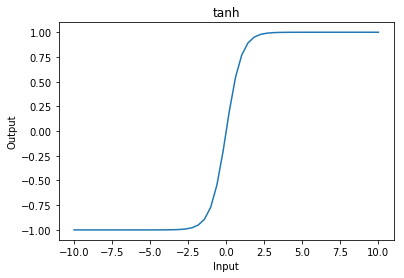

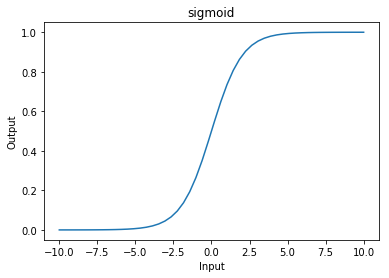

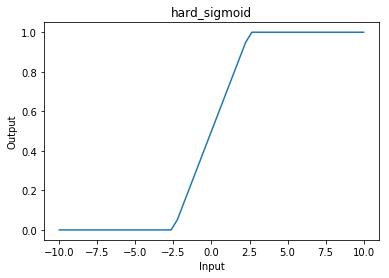

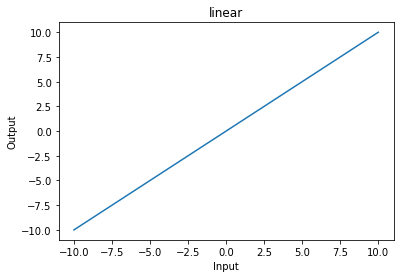

In [166]:
x=np.expand_dims(np.linspace(-10,10,50),1)

act_input=tf.keras.Input((1,)) #Notice the comma after 1, this is a 1 dimentional input to keras
output=tf.keras.layers.LeakyReLU()(act_input) #This is an "Advanced Activation, so it has it's own layer"


sess=tf.keras.backend.get_session()
output=sess.run(output,feed_dict={act_input:x})
plt.plot(x,output)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('LeakyReLU')
plt.show()
for activation in ['elu','selu','relu','softplus','softsign','tanh','sigmoid','hard_sigmoid','linear']:
    output=tf.keras.layers.Activation(activation)(act_input) 
    sess=tf.keras.backend.get_session()
    output=sess.run(output,feed_dict={act_input:x})
    plt.plot(x,output)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(activation)
    plt.show()


In [169]:
#Sigmoid

In [171]:
model=build_model(dropout_rate=0.25,nfilters=32,activation='sigmoid')
history=new_model.fit(X_train[train_data], Y_train[train_data], 
      batch_size=32, epochs=200, verbose=0,
     validation_data=(X_test,Y_test) )
score = new_model.evaluate(X_test, Y_test, verbose=0)
print("Test loss: {}, Test accuracy: {}".format(*score))

score = new_model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
print("Train loss: {}, Train accuracy: {}".format(*score))

Test loss: 0.6041515230178833, Test accuracy: 0.7734
Train loss: 0.2561815059185028, Train accuracy: 0.9059999995231628


In [ ]:
#Leaky RELU

# Something a bit more complicated

Even when over fitting we can see 

In [142]:
 
# Load pre-shuffled MNIST data into train and test sets
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#n_targets=np.max(y_test)
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255




In [143]:
#f=plt.figure(figsize=(15,3))
#plt.imshow(np.hstack(X_train[0:7]),cmap='gray') #hstack aranges the first 7 images into one long image

In [139]:
# Dreaming

In [168]:
prediction=0
doutput_dinput=tf.gradients(new_model.layers[-2].output[:,prediction],new_model.inputs)[0]



print(doutput_dinput)

sess=tf.keras.backend.get_session()

input_test=X_train[0:1].copy()
print(model.predict(input_test))

#input_test=np.random.uniform(size=(1,28,28,1))

for i in range(10):
    grads=sess.run(doutput_dinput,feed_dict={model.input:input_test})
    plt.imshow(np.squeeze(grads))
    plt.show()
    plt.imshow(np.squeeze(input_test))
    plt.show()
    print(np.linalg.norm(grads))
    
    grads/=np.linalg.norm(grads)
    input_test+=0.01*grads
    
    if i%100 ==0:
        print(model.predict(input_test)[0][prediction])

        plt.imshow(np.squeeze(input_test),cmap='gray',vmin=0,vmax=1)
        plt.show()





Tensor("gradients_2/conv2d_71/Conv2D_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
[[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.08533674
  0.08533674 0.08533674 0.08533674 0.23196931]]


InvalidArgumentError: You must feed a value for placeholder tensor 'input_37' with dtype float and shape [?,28,28,1]
	 [[{{node input_37}} = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node gradients_2/conv2d_71/Conv2D_grad/Conv2DBackpropInput/_6075}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_210_gradients_2/conv2d_71/Conv2D_grad/Conv2DBackpropInput", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_37', defined at:
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-153-8c8df9e37d0f>", line 3, in <module>
    new_model=build_model(dropout_rate=rate)
  File "<ipython-input-135-04440a2fd9f1>", line 3, in build_model
    cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_layer.py", line 229, in Input
    input_tensor=tensor)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_layer.py", line 112, in __init__
    name=self.name)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1745, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5020, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_37' with dtype float and shape [?,28,28,1]
	 [[{{node input_37}} = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node gradients_2/conv2d_71/Conv2D_grad/Conv2DBackpropInput/_6075}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_210_gradients_2/conv2d_71/Conv2D_grad/Conv2DBackpropInput", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
